This notebook uses the **SUBTLEX-CH corpus** for Chinese word frequencies:
- **Source**: [SUBTLEX-CH Database](http://www.ugent.be/pp/experimentele-psychologie/en/research/documents/subtlexch)
- **Files needed** (if regenerating from scratch):
  - `SUBTLEX-CH-WF_PoS.xlsx` - Word forms with part-of-speech tags

The raw SUBTLEX `.xlsx` files are not tracked in git due to size and licensing.
However, the processed `nouns_top2500.csv` **is tracked**, so you can run the analysis
immediately after cloning without downloading the source files.

**To regenerate from scratch**:
1. Download SUBTLEX-CH files from the link above
2. Place `SUBTLEX-CH-WF_PoS.xlsx` in the `data/` directory
3. Delete `data/nouns_top2500.csv`
4. Run the cells below

## Data Preparation

### Load Data

In [1]:
import pandas as pd
import os

# Load from existing CSV if available
if os.path.exists('data/nouns_top2500.csv'):
    print("Loading existing nouns_top2500.csv...")
    df_noun_top2500 = pd.read_csv('data/nouns_top2500.csv')
else:
    # Process from source XLSX file
    print("Processing SUBTLEX-CH-WF_PoS.xlsx to create nouns_top2500.csv...")
    df_pos = pd.read_excel('data/SUBTLEX-CH-WF_PoS.xlsx', skiprows=2)
    df_pos.columns = ['Lemma', 'WF_Lemma', 'WordForm', 'PoS', 'WF_PoS']

    df_noun = df_pos[df_pos['PoS'] == 'n']
    df_noun = df_noun.drop(columns=['PoS', 'Lemma', 'WF_Lemma'])
    df_noun = df_noun.sort_values('WF_PoS', ascending=False)

    df_noun_top2500 = df_noun.head(2500)
    df_noun_top2500 = df_noun_top2500.rename(columns={'WordForm': 'Noun'})
    df_noun_top2500 = df_noun_top2500.rename(columns={'WF_PoS': 'Frequency'})
    
    df_noun_top2500.to_csv('data/nouns_top2500.csv', index=False)
    print("Created and saved nouns_top2500.csv")

print(f"Loaded {len(df_noun_top2500)} nouns")

Loading existing nouns_top2500.csv...
Loaded 2500 nouns


### Add Translation

In [2]:
from deep_translator import GoogleTranslator
import time

df_noun_top2500 = pd.read_csv('data/nouns_top2500.csv')
translator = GoogleTranslator(source='zh-CN', target='en')

def get_english_equivalent(word):
    try:
        translation = translator.translate(word)
        return translation.strip().lower()
    except Exception as e:
        print(f"Error translating {word}: {e}")
        return 'N/A'

if 'English' not in df_noun_top2500.columns:
    df_noun_top2500['English'] = ''

translated_count = 0
for i, row in df_noun_top2500.iterrows():

    if pd.notna(row['English']) and row['English'] != '':
        continue
    
    word = row['Noun']
    equivalent = get_english_equivalent(word)
    df_noun_top2500.at[i, 'English'] = equivalent
    translated_count += 1
    
    time.sleep(0.1)

    if translated_count % 100 == 0:
        print(f"Translated {translated_count} words...")

print(f"Total words translated: {translated_count}/{len(df_noun_top2500)}\n")

df_noun_top2500.to_csv('data/nouns_top2500.csv', index=False)
print(df_noun_top2500.head(10))

Total words translated: 0/2500

  Noun  Frequency    English
0    人   194914.0     people
1    事    97710.0      thing
2   时候    52176.0       when
3   先生    46864.0  gentlemen
4    话    39887.0       talk
5   东西    37700.0      thing
6   孩子    37243.0      child
7   问题    33364.0   question
8   时间    30703.0       time
9    钱    29217.0      money


### Create Embeddings    

In [3]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

model_name = "bert-base-chinese"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

model.eval()

nouns = df_noun_top2500['Noun'].tolist()
embeddings = []

for noun in nouns:
    inputs = tokenizer(noun, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    embeddings.append(emb)

embeddings = np.stack(embeddings) 

/opt/anaconda3/envs/hanzi/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Clustering Method Comparison

Grid Search for Optimal Number of Clusters (5-30)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)




Optimal K-means:        7 clusters (silhouette=0.0481)
Optimal Agglomerative:  15 clusters (silhouette=0.0434)


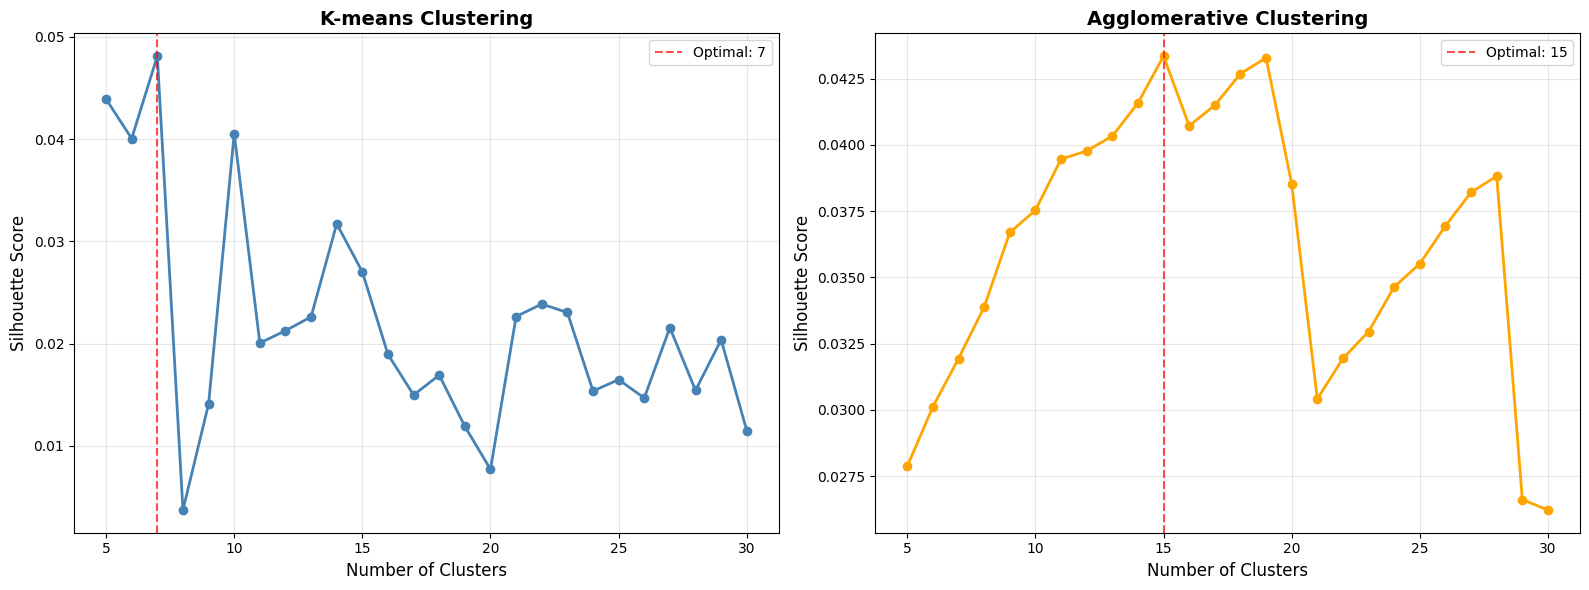



K-MEANS CLUSTERING ANALYSIS (n_clusters=7)

Cluster 0 (size: 67):
  1. 机器     - machine              (freq: 1709)
  2. 女人     - woman                (freq: 14388)
  3. 男人     - man                  (freq: 11608)

Cluster 1 (size: 152):
  1. 技术     - technology           (freq: 2136)
  2. 军队     - army                 (freq: 1870)
  3. 名单     - list                 (freq: 2212)

Cluster 2 (size: 21):
  1. 脑子     - brain                (freq: 2401)
  2. 孩子     - child                (freq: 37243)
  3. 小子     - boy                  (freq: 4818)

Cluster 3 (size: 72):
  1. 话      - talk                 (freq: 39887)
  2. 生命     - life                 (freq: 5898)
  3. 时代     - era                  (freq: 1544)

Cluster 4 (size: 44):
  1. 姑娘     - girl                 (freq: 3765)
  2. 妹妹     - younger sister       (freq: 3262)
  3. 妻子     - wife                 (freq: 6494)

Cluster 5 (size: 30):
  1. 情绪     - mood                 (freq: 1446)
  2. 灵魂     - soul                 (freq: 24

In [4]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Use top 500 embeddings
top_n = 500
embeddings_top500 = embeddings[:top_n]
nouns_top500 = df_noun_top2500.head(top_n)

# Grid search parameters
cluster_range = range(5, 31)  # 5 to 30 clusters

# Store results
agg_scores = []
kmeans_scores = []

print("Grid Search for Optimal Number of Clusters (5-30)")

for n_clusters in cluster_range:
    # Agglomerative
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    agg_labels = agg.fit_predict(embeddings_top500)
    agg_silhouette = silhouette_score(embeddings_top500, agg_labels)
    agg_scores.append(agg_silhouette)
    
    # K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(embeddings_top500)
    kmeans_silhouette = silhouette_score(embeddings_top500, kmeans_labels)
    kmeans_scores.append(kmeans_silhouette)

# Find optimal number of clusters for each method
optimal_agg_idx = np.argmax(agg_scores)
optimal_agg_clusters = list(cluster_range)[optimal_agg_idx]

optimal_kmeans_idx = np.argmax(kmeans_scores)
optimal_kmeans_clusters = list(cluster_range)[optimal_kmeans_idx]

print("\n" + "=" * 60)
print(f"\nOptimal K-means:        {optimal_kmeans_clusters} clusters (silhouette={kmeans_scores[optimal_kmeans_idx]:.4f})")
print(f"Optimal Agglomerative:  {optimal_agg_clusters} clusters (silhouette={agg_scores[optimal_agg_idx]:.4f})")

# Plot silhouette scores - side by side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# K-means plot
ax1.plot(cluster_range, kmeans_scores, marker='o', linewidth=2, markersize=6, color='steelblue')
ax1.axvline(x=optimal_kmeans_clusters, color='r', linestyle='--', alpha=0.7, 
            label=f'Optimal: {optimal_kmeans_clusters}')
ax1.set_xlabel('Number of Clusters', fontsize=12)
ax1.set_ylabel('Silhouette Score', fontsize=12)
ax1.set_title('K-means Clustering', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Agglomerative plot
ax2.plot(cluster_range, agg_scores, marker='o', linewidth=2, markersize=6, color='orange')
ax2.axvline(x=optimal_agg_clusters, color='r', linestyle='--', alpha=0.7, 
            label=f'Optimal: {optimal_agg_clusters}')
ax2.set_xlabel('Number of Clusters', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Agglomerative Clustering', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Function to find closest nouns to centroids using KNN
def find_representative_nouns(embeddings, labels, nouns_df, n_clusters, n_representatives=3):
    """Find the n closest nouns to each cluster centroid using KNN"""
    results = []
    
    for cluster_id in range(n_clusters):
        # Get all points in this cluster
        cluster_mask = labels == cluster_id
        cluster_embeddings = embeddings[cluster_mask]
        cluster_nouns = nouns_df[cluster_mask]
        
        # Calculate centroid
        centroid = cluster_embeddings.mean(axis=0).reshape(1, -1)
        
        # Use KNN to find closest nouns to centroid
        knn = NearestNeighbors(n_neighbors=min(n_representatives, len(cluster_embeddings)))
        knn.fit(cluster_embeddings)
        distances, indices = knn.kneighbors(centroid)
        
        # Get the representative nouns
        representative_nouns = cluster_nouns.iloc[indices[0]]
        
        results.append({
            'cluster_id': cluster_id,
            'size': cluster_mask.sum(),
            'representatives': representative_nouns[['Noun', 'English', 'Frequency']].to_dict('records')
        })
    
    return results

# Analyze K-means clusters
print("\n" + "=" * 60)
print(f"\nK-MEANS CLUSTERING ANALYSIS (n_clusters={optimal_kmeans_clusters})")
print("=" * 60)

kmeans_optimal = KMeans(n_clusters=optimal_kmeans_clusters, random_state=42, n_init=10)
kmeans_optimal_labels = kmeans_optimal.fit_predict(embeddings_top500)

kmeans_results = find_representative_nouns(
    embeddings_top500, 
    kmeans_optimal_labels, 
    nouns_top500, 
    optimal_kmeans_clusters
)

for cluster_info in kmeans_results:
    print(f"\nCluster {cluster_info['cluster_id']} (size: {cluster_info['size']}):")
    for i, rep in enumerate(cluster_info['representatives'], 1):
        print(f"  {i}. {rep['Noun']:6s} - {rep['English']:20s} (freq: {rep['Frequency']:.0f})")

# Analyze Agglomerative clusters
print("\n" + "=" * 60)
print(f"\nAGGLOMERATIVE CLUSTERING ANALYSIS (n_clusters={optimal_agg_clusters})")
print("=" * 60)

agg_optimal = AgglomerativeClustering(n_clusters=optimal_agg_clusters)
agg_optimal_labels = agg_optimal.fit_predict(embeddings_top500)

agg_results = find_representative_nouns(
    embeddings_top500, 
    agg_optimal_labels, 
    nouns_top500, 
    optimal_agg_clusters
)

for cluster_info in agg_results:
    print(f"\nCluster {cluster_info['cluster_id']} (size: {cluster_info['size']}):")
    for i, rep in enumerate(cluster_info['representatives'], 1):
        print(f"  {i}. {rep['Noun']:6s} - {rep['English']:20s} (freq: {rep['Frequency']:.0f})")

print("\n" + "=" * 60)